In [1]:
import pandas as pd
import math
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.MolStandardize import rdMolStandardize
#IPythonConsole.drawOptions.comicMode=True
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.info')
import rdkit
from rdkit.Chem.SaltRemover import SaltRemover
print(rdkit.__version__)
import numpy as np

from multiprocessing import Pool
from tqdm import tqdm

from matplotlib import pyplot as plt

2019.03.1


In [2]:
import os
import sys
sys.path.append('/scratch/work/masooda1/ToxBERT/src')

import logging
from typing import Tuple, Sequence, Any, Dict, Union, Optional

import numpy as np
import pandas as pd
import yaml
from tqdm import tqdm
import torch

from molbert.utils.featurizer.molfeaturizer import SmilesIndexFeaturizer
from molbert.models.smiles import SmilesMolbertModel
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
logger = logging.getLogger(__name__)
from multiprocessing import Pool

class MolBertFeaturizer:
    """
    This featurizer takes a molbert model and transforms the input data and
    returns the representation in the last layer (pooled output and sequence_output).
    """

    def __init__(
        self,
        model,
        featurizer,
        device: str = None,
        embedding_type: str = 'pooled',
        max_seq_len: Optional[int] = None,
        permute: bool = False,
    ) -> None:
        """
        Args:
            checkpoint_path: path or S3 location of trained model checkpoint
            device: device for torch
            embedding_type: method to reduce MolBERT encoding to an output set of features. Default: 'pooled'
                Other options are embeddings summed or concat across layers, and then averaged
                Raw sequence and pooled output is also available (set to 'dict')
                average-sum-[2|4], average-cat-[2,4], average-[1|2|3|4], average-1-cat-pooled, pooled, dict
            max_seq_len: used by the tokenizer, SMILES longer than this will fail to featurize
                MolBERT was trained with SuperPositionalEncodings (TransformerXL) to decoupled from the training setup
                By default the training config is used (128). If you have long SMILES to featurize, increase this value
        """
        super().__init__()
        self.device = device or 'cuda' if torch.cuda.is_available() else 'cpu'
        self.embedding_type = embedding_type
        self.max_seq_len = max_seq_len
        self.permute = permute

        # load smiles index featurizer
        self.featurizer = featurizer

        # load model
        self.model = model

    def __getstate__(self):
        self.__dict__.update({'model': self.model.to('cpu')})
        self.__dict__.update({'device': 'cpu'})
        return self.__dict__

    @property

    def transform_single(self, smiles: str) -> Tuple[np.ndarray, bool]:
        features, valid = self.transform([smiles])
        return features, valid[0]

    def transform(self, molecules: Sequence[Any]) -> Tuple[Union[Dict, np.ndarray], np.ndarray]:
        input_ids, valid = self.featurizer.transform(molecules)

        input_ids = self.trim_batch(input_ids, valid)

        token_type_ids = np.zeros_like(input_ids, dtype=np.int64)
        attention_mask = np.zeros_like(input_ids, dtype=np.int64)

        attention_mask[input_ids != 0] = 1

        input_ids = torch.tensor(input_ids, dtype=torch.long, device=self.device)
        token_type_ids = torch.tensor(token_type_ids, dtype=torch.long, device=self.device)
        attention_mask = torch.tensor(attention_mask, dtype=torch.long, device=self.device)

        with torch.no_grad():
            outputs = self.model.model.bert(
                input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask
            )

        sequence_output, pooled_output = outputs

        # set invalid outputs to 0s
        valid_tensor = torch.tensor(
            valid, dtype=sequence_output.dtype, device=sequence_output.device, requires_grad=False
        )

        pooled_output = pooled_output * valid_tensor[:, None]
        sequence_out = sequence_output * valid_tensor[:, None, None]

        sequence_out = sequence_out.detach().cpu().numpy()
        pooled_output = pooled_output.detach().cpu().numpy()
        out = pooled_output

        return out, valid

    @staticmethod
    def trim_batch(input_ids, valid):

        # trim input horizontally if there is at least 1 valid data point
        if any(valid):
            _, cols = np.where(input_ids[valid] != 0)
        # else trim input down to 1 column (avoids empty batch error)
        else:
            cols = np.array([0])

        max_idx: int = int(cols.max().item() + 1)

        input_ids = input_ids[:, :max_idx]

        return input_ids

In [3]:
def standardize(smiles,remover=SaltRemover()):
    config = {}
    config["StandardizeSmiles"] = True
    config["FragmentParent"] = False
    config["SaltRemover"] = True
    config["isomericSmiles"] = False
    config["kekuleSmiles"] = True
    config["canonical"] = True
    # follows the steps in
    # https://github.com/rdkit/rdkit/blob/master/Docs/Notebooks/MolStandardize.ipynb
    try:
        if config["StandardizeSmiles"]:
            # removeHs, disconnect metal atoms, normalize the molecule, reionize the molecule

                smiles = rdMolStandardize.StandardizeSmiles(smiles)

        mol = Chem.MolFromSmiles(smiles)
        # remove salts
        if config["SaltRemover"]:
            mol = remover.StripMol(mol, dontRemoveEverything=False) 

        if config["FragmentParent"]:
            mol = rdMolStandardize.FragmentParent(mol) 

        if config["kekuleSmiles"]:
            Chem.Kekulize(mol, clearAromaticFlags=True)
        normalized_smiles = Chem.MolToSmiles(mol, 
                            isomericSmiles = config["isomericSmiles"],
                            kekuleSmiles = config["kekuleSmiles"],
                            canonical = config["canonical"],
                            allHsExplicit = False)
        if normalized_smiles == '':
            normalized_smiles = np.nan
    except:
        normalized_smiles = np.nan
    return normalized_smiles

def normalize_smiles_parallel(smiles_list):
    with Pool() as pool:
        results = []
        total = len(smiles_list)
        with tqdm(total=total, ncols=80, desc="Processing") as pbar:
            for normalized_smiles in pool.imap(standardize, smiles_list):
                results.append(normalized_smiles)
                pbar.update(1)
    return results

In [4]:
TG_GATES_SMILES = pd.read_excel("/scratch/work/masooda1/ToxBERT/data/rawdata/Animal_GAN_TGGATES_SMILES.xlsx")
TG_GATES_SMILES.head()

,CompoundName,PubChem_CID,SMILES,Average_Structural_Similarity_Score,ATC,Initial_Approval_Year
0,acetaminophen,1983,CC(=O)NC1=CC=C(C=C1)O,0.985526,N02,1949.0
1,isoniazid,3767,C1=CN=CC=C1C(=O)NN,0.985526,J04,1967.0
2,carbon tetrachloride,5943,C(Cl)(Cl)(Cl)Cl,0.985525,NaN,NaN
3,valproic acid,3121,CCCC(CCC)C(=O)O,0.985526,N03,1978.0
4,phenobarbital,4763,CCC1(C(=O)NC(=O)NC1=O)C2=CC=CC=C2,0.985526,N05|N03,1951.0


In [5]:
print(TG_GATES_SMILES.SMILES.nunique())
normalized_smiles_list = normalize_smiles_parallel(TG_GATES_SMILES.SMILES.tolist())
TG_GATES_SMILES['Normalized_SMILES'] = normalized_smiles_list

print(TG_GATES_SMILES.Normalized_SMILES.nunique())

138


Processing: 100%|████████████████████████████| 138/138 [00:00<00:00, 228.50it/s]


138


# Pass through BERT to filter invalid SMILES

In [6]:
path_to_checkpoint = '/scratch/work/masooda1/ToxBERT/molbert_100epochs/checkpoints/last.ckpt'
model_dir = os.path.dirname(os.path.dirname(path_to_checkpoint))
hparams_path = os.path.join(model_dir, 'hparams.yaml')
            
# load config
with open(hparams_path) as yaml_file:
    config_dict = yaml.load(yaml_file, Loader=yaml.FullLoader)
config_dict["pretrained_model_path"] = path_to_checkpoint

model = SmilesMolbertModel(config_dict)
checkpoint = torch.load(config_dict["pretrained_model_path"], map_location=lambda storage, loc: storage)
model.load_state_dict(checkpoint['state_dict'], strict = False)
device = "cpu"
model.eval()
model.freeze()
model = model.to(device)

featurizer = SmilesIndexFeaturizer.bert_smiles_index_featurizer(126, permute = False)
f = MolBertFeaturizer(model = model,
                        featurizer= featurizer,
                        device = device)

42


In [7]:
smiles_list = TG_GATES_SMILES.Normalized_SMILES.tolist()

batch_size = 5
batches = [smiles_list[i:i+batch_size] for i in range(0, len(smiles_list), batch_size)]
print(len(smiles_list))

features_all, masks_all = [],[]
for batch_smiles in tqdm(batches):
    features, masks = f.transform(batch_smiles)
    torch.cuda.empty_cache()
    features_all.append(features)  # Store features for each batch
    masks_all.extend(masks.tolist())

# Convert features list to numpy array
features_all = np.vstack(features_all)  # Combine all features into one array
features_all = features_all[masks_all]  # Filter features using masks

# Filter original data
TG_GATES_SMILES_filtered = TG_GATES_SMILES[masks_all].reset_index(drop=True)

# Create features dataframe with SMILES
feature_columns = [f'feature_{i}' for i in range(features_all.shape[1])]
features_df = pd.DataFrame(features_all, columns=feature_columns)
features_df.insert(0,'Normalized_SMILES', TG_GATES_SMILES_filtered['Normalized_SMILES'])

# Print statistics
filtered_smiles = len(smiles_list) - sum(masks_all)
print(f"We filtered {filtered_smiles} SMILES")
print(f"Remaining SMILES: {sum(masks_all)}")
print("Script Completed")

138


100%|██████████| 28/28 [00:21<00:00,  1.31it/s]

We filtered 5 SMILES
Remaining SMILES: 133
Script Completed


In [8]:
TG_data = pd.read_csv("/scratch/work/masooda1/ToxBERT/data/rawdata/open_tggates_biochemistry.csv", encoding = "cp1252")
print(TG_data.shape)
TG_data.head()

(23643, 30)


,EXP_ID,GROUP_ID,INDIVIDUAL_ID,COMPOUND_NAME,SINGLE_REPEAT_TYPE,SACRIFICE_PERIOD,DOSE,DOSE_UNIT,DOSE_LEVEL,ALP(IU/L),...,Cl(meq/L),Ca(mg/dL),IP(mg/dL),TP(g/dL),RALB(g/dL),A/G,AST(IU/L),ALT(IU/L),LDH(IU/L),GTP(IU/L)
0,40,1,1,acetaminophen,Single,3 hr,0,mg/kg,Control,877.0,...,102.0,10.9,12.1,5.6,3.6,1.8,83.0,50.0,128.0,2.0
1,40,1,2,acetaminophen,Single,3 hr,0,mg/kg,Control,917.0,...,106.0,10.4,12.9,5.6,3.5,1.7,59.0,29.0,79.0,2.0
2,40,1,3,acetaminophen,Single,3 hr,0,mg/kg,Control,751.0,...,104.0,10.7,11.5,5.3,3.5,1.9,64.0,33.0,186.0,1.0
3,40,1,4,acetaminophen,Single,3 hr,0,mg/kg,Control,742.0,...,104.0,11.0,11.4,5.4,3.6,2.0,61.0,29.0,93.0,1.0
4,40,1,5,acetaminophen,Single,3 hr,0,mg/kg,Control,923.0,...,101.0,10.9,11.5,5.5,3.6,1.9,64.0,34.0,70.0,4.0


In [9]:
desired_columns = ['COMPOUND_NAME','INDIVIDUAL_ID','SACRIFICE_PERIOD','DOSE_LEVEL',
                   'ALP(IU/L)','TC(mg/dL)','TG(mg/dL)','TBIL(mg/dL)',
                   'DBIL(mg/dL)','AST(IU/L)','ALT(IU/L)','LDH(IU/L)','GTP(IU/L)']
selected_data = TG_data.loc[:,desired_columns]

# Do we have control group for each drug-time ?
group = selected_data.groupby(['COMPOUND_NAME',"SACRIFICE_PERIOD"])
missing_control_groups = group.filter(lambda x: "Control" not in x['DOSE_LEVEL'].values)
if missing_control_groups.shape[0] != 0:
    raise ValueError(f"No control found at {missing_control_groups.COMPOUND_NAME, missing_control_groups.SACRIFICE_PERIOD}")

# group by drug-dose-time and aggregate across animals
group = selected_data.groupby(['COMPOUND_NAME',"SACRIFICE_PERIOD","DOSE_LEVEL"])
    

In [10]:
def tbil_label(value,control_mean):
    if 0<= control_mean <0.1:
        label = value > 0.1

    elif 0.1<= control_mean<0.25:
        label = value >= 0.35
    else:
        label = value >= 0.5
    return label
def dbil_label(value,control_mean):
    if control_mean <=0.1:
        label = value>= 0.15
    else:
        label = value>=0.3
    return label

In [11]:
compound = selected_data.COMPOUND_NAME.unique()
DOSE_LEVEL = sorted(selected_data.DOSE_LEVEL.unique())
SACRIFICE_PERIOD = selected_data.SACRIFICE_PERIOD.unique()
animals_th = 1

columns_ratio= [('ALP(IU/L)',1.5),('AST(IU/L)',2),('ALT(IU/L)',2),
                ('GTP(IU/L)',3),('TC(mg/dL)',1.5),('TG(mg/dL)',3),
                ('TBIL(mg/dL)',tbil_label),('DBIL(mg/dL)',dbil_label)]

results = []
for i, cmp in enumerate(compound):

    # Dose, time dependent labels
    for dose in DOSE_LEVEL:
        for time in SACRIFICE_PERIOD:

            if dose == "Control":
                try: 
                    control = group.get_group((cmp,time,"Control"))
                except:
                    control = None
            else:
                try:
                    # if drug is tested at particular dose and time
                    compound_data = group.get_group((cmp,time,dose))

                    # store dose, and time information
                    cmp_records = {'COMPOUND_NAME':cmp,
                                'DOSE_LEVEL': dose,
                                'SACRIFICE_PERIOD':time}
                    
                    # label = nan --> if compound is not tested
                    # label = 1 --> observed value is greate than th
                    # label = 0 --> if not true

                    for finding, ratio in columns_ratio:

                        # if finding is DBIL, TBIL
                        if finding in ['DBIL(mg/dL)', 'TBIL(mg/dL)']:
                            if finding == 'DBIL(mg/dL)':
                                labels = dbil_label(compound_data.loc[:,finding].values,
                                                control.loc[:,finding].mean())
                                labels = (labels.sum() > animals_th).astype(int)
                            if finding == 'TBIL(mg/dL)':
                                labels = tbil_label(compound_data.loc[:,finding].values,
                                                control.loc[:,finding].mean())
                                labels = (labels.sum() > animals_th).astype(int)

                        #  All remaining findings                
                        elif finding not in ['DBIL(mg/dL)', 'TBIL(mg/dL)']:
                            labels = compound_data.loc[:,finding].values > ratio * control.loc[:,finding].mean()
                            labels = (labels.sum() > animals_th).astype(int)
                        else:
                            labels = 0
                        cmp_records[finding] = labels
                except:
                    # if drug is not being tested at particular dose and time
                    # store dose, and time information
                    cmp_records = {'COMPOUND_NAME':cmp,
                                'DOSE_LEVEL': dose,
                                'SACRIFICE_PERIOD':time}
                    
                    # store labels
                    findings = [key for key, _ in columns_ratio]
                    cmp_records.update({finding: None for finding in findings})
                results.append(cmp_records)

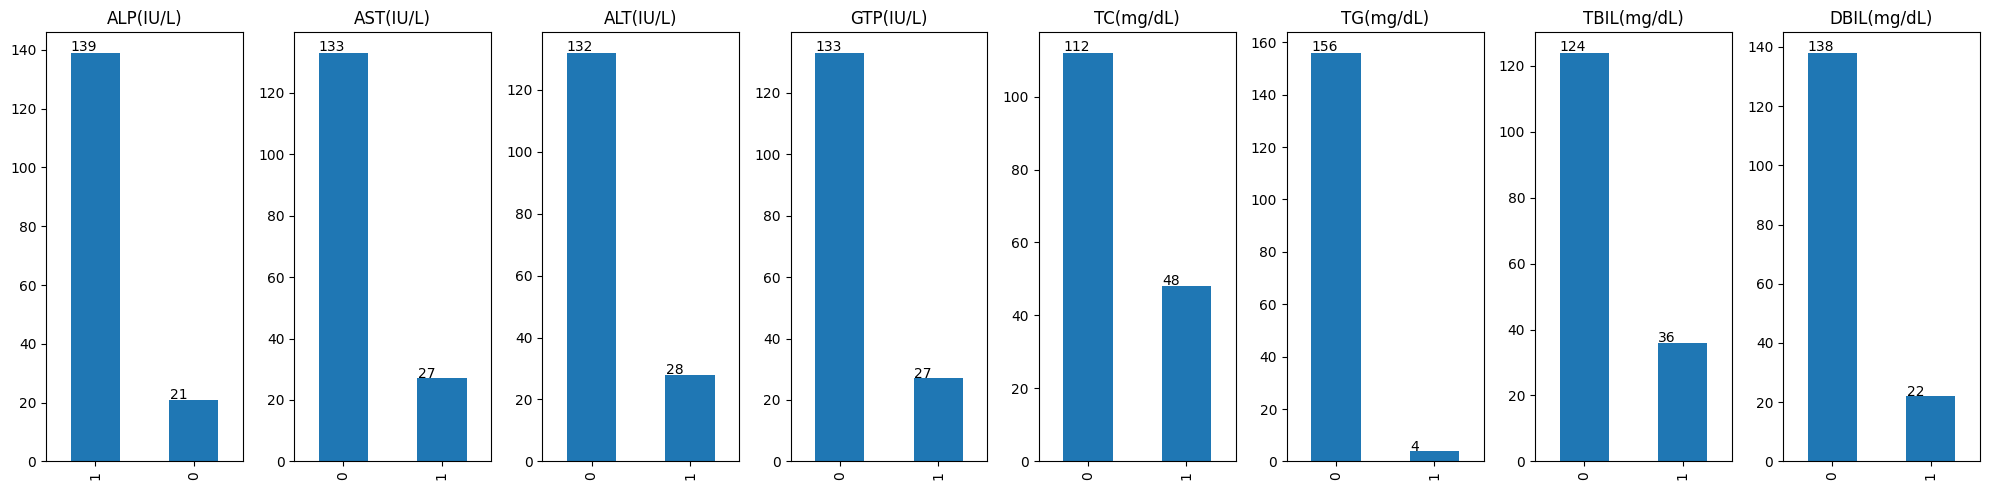

In [12]:
results = pd.DataFrame(results)
# Nominal toxicity (drop dose and time)
# if Findings is positive at any dose and time,consider it positive
results = results.groupby(['COMPOUND_NAME']).sum() >= 1
results = results.astype(int).reset_index()
results

r = results.set_index('COMPOUND_NAME').dropna(axis=0,how='all')
fig,ax = plt.subplots(1,len(r.columns),figsize=(20,5))
for idx,q in enumerate(r.columns):
    t_ax = r[q].value_counts().plot.bar(ax=ax[idx],title=q)
    for p in t_ax.patches:
        t_ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.tight_layout()

In [13]:
results

,COMPOUND_NAME,ALP(IU/L),AST(IU/L),ALT(IU/L),GTP(IU/L),TC(mg/dL),TG(mg/dL),TBIL(mg/dL),DBIL(mg/dL)
0,1% cholesterol + 0.25% sodium cholate,1,0,0,0,1,0,0,0
1,"2,4-dinitrophenol",1,0,0,0,0,0,0,0
2,2-nitrofluorene,0,0,0,0,0,0,0,0
3,3-methylcholanthrene,0,0,0,0,0,0,0,0
4,LPS,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
155,triazolam,1,0,0,0,0,0,0,0
156,trimethadione,1,1,0,0,0,0,0,0
157,tunicamycin,0,0,0,0,0,0,0,0
158,valproic acid,1,0,0,0,0,0,0,1


In [14]:
TG_data_with_SMILES = pd.merge(TG_GATES_SMILES_filtered, results, 
                               left_on = "CompoundName", right_on = "COMPOUND_NAME", how = "left")
TG_data_with_SMILES

,CompoundName,PubChem_CID,SMILES,Average_Structural_Similarity_Score,ATC,Initial_Approval_Year,Normalized_SMILES,COMPOUND_NAME,ALP(IU/L),AST(IU/L),ALT(IU/L),GTP(IU/L),TC(mg/dL),TG(mg/dL),TBIL(mg/dL),DBIL(mg/dL)
0,acetaminophen,1983,CC(=O)NC1=CC=C(C=C1)O,0.985526,N02,1949.0,CC(=O)NC1=CC=C(O)C=C1,acetaminophen,1,1,1,0,1,0,0,0
1,isoniazid,3767,C1=CN=CC=C1C(=O)NN,0.985526,J04,1967.0,NNC(=O)C1=CC=NC=C1,isoniazid,0,0,0,0,0,0,1,0
2,carbon tetrachloride,5943,C(Cl)(Cl)(Cl)Cl,0.985525,NaN,NaN,ClC(Cl)(Cl)Cl,carbon tetrachloride,1,1,1,0,0,0,0,1
3,valproic acid,3121,CCCC(CCC)C(=O)O,0.985526,N03,1978.0,CCCC(CCC)C(=O)O,valproic acid,1,0,0,0,0,0,0,1
4,phenobarbital,4763,CCC1(C(=O)NC(=O)NC1=O)C2=CC=CC=C2,0.985526,N05|N03,1951.0,CCC1(C2=CC=CC=C2)C(=O)NC(=O)NC1=O,phenobarbital,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,"2,4-dinitrophenol",1493,C1=CC(=C(C=C1[N+](=O)[O-])[N+](=O)[O-])O,0.985526,NaN,NaN,O=[N+]([O-])C1=CC=C(O)C([N+](=O)[O-])=C1,"2,4-dinitrophenol",1,0,0,0,0,0,0,0
129,fluoxetine hydrochloride,62857,CNCCC(C1=CC=CC=C1)OC2=CC=C(C=C2)C(F)(F)F.Cl,0.915545,NaN,NaN,CNCCC(OC1=CC=C(C(F)(F)F)C=C1)C1=CC=CC=C1,fluoxetine hydrochloride,1,1,1,0,0,0,0,0
130,methylene dianiline,136430,C1=CC=C(C=C1)NCNC2=CC=CC=C2,0.985526,NaN,NaN,C1=CC=C(NCNC2=CC=CC=C2)C=C1,methylene dianiline,1,1,1,1,1,0,1,1
131,butylated hydroxyanisole,8456,CC(C)(C)C1=C(C=CC(=C1)OC)O,0.985526,NaN,NaN,COC1=CC=C(O)C(C(C)(C)C)=C1,butylated hydroxyanisole,1,0,1,0,1,0,1,0


# Splits 
### Random split
### Time split
### Therapeutic class split

In [15]:
splits = pd.read_excel("/scratch/work/masooda1/ToxBERT/data/rawdata/Animal_GAN_TGGATES_splits.xlsx")
splits = splits[["COMPOUND_NAME", "Split_RandomPick","Split_Structure","Split_ATC","Split_Time"]]
splits = splits.dropna().reset_index(drop = True)
splits = splits.groupby("COMPOUND_NAME").agg('first').reset_index()
splits

,COMPOUND_NAME,Split_RandomPick,Split_Structure,Split_ATC,Split_Time
0,"2,4-dinitrophenol",Test,Training,Training,Training
1,WY-14643,Training,Training,Training,Training
2,acarbose,Training,Test,Test,Test
3,acetamidofluorene,Test,Training,Training,Training
4,acetaminophen,Training,Training,Training,Training
...,...,...,...,...,...
133,triamterene,Training,Training,Training,Training
134,triazolam,Training,Training,Training,Training
135,trimethadione,Training,Training,Training,Training
136,valproic acid,Training,Training,Training,Training


In [16]:
TG_data_with_SMILES_splits = pd.merge(TG_data_with_SMILES, splits, on = "COMPOUND_NAME", how = "left")

In [17]:
split_types = ["Split_RandomPick", "Split_Structure", "Split_ATC", "Split_Time"]
#split_types = ["Split_Structure"]

selected_cols = ['Normalized_SMILES','ALP(IU/L)', 'AST(IU/L)',
                   'ALT(IU/L)', 'GTP(IU/L)', 'TC(mg/dL)', 'TBIL(mg/dL)',
                   'DBIL(mg/dL)']

for split_type in split_types:
    train = TG_data_with_SMILES_splits[TG_data_with_SMILES_splits[split_type] == "Training"].reset_index(drop = True)
    test = TG_data_with_SMILES_splits[TG_data_with_SMILES_splits[split_type] == "Test"].reset_index(drop = True)
    train = train[selected_cols]
    test = test[selected_cols]
    train.rename(columns = {"Normalized_SMILES": "SMILES"}, inplace = True)
    test.rename(columns = {"Normalized_SMILES": "SMILES"}, inplace = True)
    
    train.to_csv(f"/scratch/work/masooda1/ToxBERT/data/downstream_data/TG_train_{split_type}.csv", index = False)
    test.to_csv(f"/scratch/work/masooda1/ToxBERT/data/downstream_data/TG_test_{split_type}.csv", index = False)

    print(split_type)
    print(test.sum(axis = 0))

Split_RandomPick
SMILES         C#CC1(O)CCC2C3CCC4=CC5=C(C=NO5)CC4(C)C3CCC21CO...
ALP(IU/L)                                                     24
AST(IU/L)                                                      7
ALT(IU/L)                                                      8
GTP(IU/L)                                                      6
TC(mg/dL)                                                     12
TBIL(mg/dL)                                                   11
DBIL(mg/dL)                                                    4
dtype: object
Split_Structure
SMILES         ClC(Cl)(Cl)ClCOC1C=COC2(C)OC3=C(C)C(O)=C4C(O)=...
ALP(IU/L)                                                     22
AST(IU/L)                                                      5
ALT(IU/L)                                                      5
GTP(IU/L)                                                      4
TC(mg/dL)                                                      8
TBIL(mg/dL)                                

In [31]:
selected_cols = ['ALP(IU/L)', 'AST(IU/L)',
                   'ALT(IU/L)', 'GTP(IU/L)', 'TC(mg/dL)', 'TBIL(mg/dL)',
                   'DBIL(mg/dL)']
pos = (TG_data_with_SMILES_splits[selected_cols] == 1).sum()
neg = (TG_data_with_SMILES_splits[selected_cols] == 0).sum()
pos_neg_ratio = pos/neg
pos_neg_ratio = pd.DataFrame(pos_neg_ratio).reset_index()
pos_neg_ratio.columns = ["Targets", "weights"]
pos_neg_ratio.to_csv("/scratch/work/masooda1/ToxBERT/data/downstream_data/TG_data_pos_neg_ratio.csv", index = False)

In [1]:
import pandas as pd

In [4]:
pd.read_csv("/scratch/work/masooda1/ToxBERT/data/downstream_data/TG_train_Split_RandomPick.csv").shape

(109, 8)